In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt
import calendar

In [3]:
def substract_year(date):
    one_year_delta = dt.timedelta(days=366 if ((date.month < 3 and calendar.isleap(date.year-1)) or
                                               (date.month >= 3 and calendar.isleap(date.year))) else 365)
    return date - one_year_delta

# Reflect Tables into SQLAlchemy ORM

In [66]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
# create engine to hawaii.sqlite
dbpath="sqlite:///Resources/hawaii.sqlite"
engine = create_engine(dbpath)

In [6]:
# reflect an existing database into a new model
# Declare a Base using `automap_base()`
Base = automap_base()

In [7]:
# reflect the tables
# Use the Base class to reflect the database tables
Base.prepare(engine, reflect=True)

In [8]:
# View all of the classes that automap found
# Print all of the classes mapped to the Base
Base.classes.keys()

['measurement', 'station']

In [9]:
# Save references to each table
# Assign the measurement class to a variable called `Measurement`
Measurement = Base.classes.measurement
# Assign the station class to a variable called `Station`
Station = Base.classes.station

In [10]:
# Create our session (link) from Python to the DB
# Create a session
session = Session(engine)

# Exploratory Precipitation Analysis

In [11]:
# Find the most recent date in the data set.

# Latest Date
session.query(Measurement.date).order_by(Measurement.date.desc()).first()

('2017-08-23')

In [12]:
# Earliest Date
session.query(Measurement.date).order_by(Measurement.date).first()

('2010-01-01')

In [13]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 

# Starting from the most recent data point in the database. 
latest_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]

In [81]:
# Calculate the date one year from the last date in data set.

# Convert string date to date
date_object = dt.datetime.strptime(latest_date, '%Y-%m-%d').date()

# Substract a year from the lastest date
a_year_before_latest_date = substract_year(date_object)
print(a_year_before_latest_date)

2016-08-23


In [15]:
# Perform a query to retrieve the data and precipitation scores
precipitation_scores = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= a_year_before_latest_date).\
    filter(Measurement.date <= latest_date).all()

In [25]:
# Save the query results as a Pandas DataFrame and set the index to the date column
prcp_df = pd.DataFrame(precipitation_scores, columns=['date', 'prcp'])
prcp_df.set_index('date', inplace=True)

# Sort the dataframe by date
prcp_df.sort_values(by='date', inplace=True)

# Drop all rows with missing information
prcp_df.dropna(how='any', inplace=True)
prcp_df

,prcp
date,
2016-08-23,0.00
2016-08-23,1.79
2016-08-23,0.05
2016-08-23,0.15
2016-08-23,0.70
...,...
2017-08-22,0.00
2017-08-23,0.00
2017-08-23,0.00


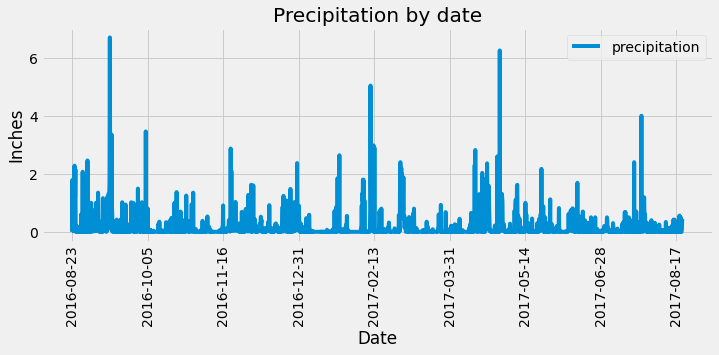

In [36]:
# Use Pandas Plotting with Matplotlib to plot the data
prcp_df.plot(kind='line', figsize=(10,4))
plt.tight_layout()
plt.xticks(rotation=90)
plt.title('Precipitation by date')
plt.xlabel('Date')
plt.ylabel('Inches')
plt.legend(['precipitation'])
plt.show()

In [37]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp_df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [48]:
# Design a query to calculate the total number stations in the dataset
session.query(Station).count()

9

In [52]:
# total number of observations in the dataset
session.query(Measurement).count()

19550

In [51]:
session.query(Station,Measurement).\
    filter(Station.station  == Measurement.station).\
    count()

19550

In [47]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
sel = [Station.station, 
       func.count(Measurement.id)]
active_stations = session.query(*sel).\
    filter(Station.station  == Measurement.station).\
    group_by(Station.station).\
    order_by(func.count(Measurement.id).desc()).all()
active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [54]:
most_active_station_id = active_stations[0][0]
most_active_station_id

'USC00519281'

In [60]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
sel = [func.min(Measurement.tobs),
       func.max(Measurement.tobs),
       func.avg(Measurement.tobs)]
most_active_station_temps = session.query(*sel).\
    filter(Measurement.station == most_active_station_id).all()
most_active_station_temps

[(54.0, 85.0, 71.66378066378067)]

In [74]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station 
most_active_station_last_year = session.query(Measurement.tobs).\
    filter(Measurement.date >= a_year_before_latest_date).\
    filter(Measurement.date <= latest_date).\
    filter(Measurement.station == most_active_station_id).all()
most_active_station_last_year

[(77.0),
 (77.0),
 (80.0),
 (80.0),
 (75.0),
 (73.0),
 (78.0),
 (77.0),
 (78.0),
 (80.0),
 (80.0),
 (78.0),
 (78.0),
 (78.0),
 (73.0),
 (74.0),
 (80.0),
 (79.0),
 (77.0),
 (80.0),
 (76.0),
 (79.0),
 (75.0),
 (79.0),
 (78.0),
 (79.0),
 (78.0),
 (78.0),
 (76.0),
 (74.0),
 (77.0),
 (78.0),
 (79.0),
 (79.0),
 (77.0),
 (80.0),
 (78.0),
 (78.0),
 (78.0),
 (77.0),
 (79.0),
 (79.0),
 (79.0),
 (79.0),
 (75.0),
 (76.0),
 (73.0),
 (72.0),
 (71.0),
 (77.0),
 (79.0),
 (78.0),
 (79.0),
 (77.0),
 (79.0),
 (77.0),
 (78.0),
 (78.0),
 (78.0),
 (78.0),
 (77.0),
 (74.0),
 (75.0),
 (76.0),
 (73.0),
 (76.0),
 (74.0),
 (77.0),
 (76.0),
 (76.0),
 (74.0),
 (75.0),
 (75.0),
 (75.0),
 (75.0),
 (71.0),
 (63.0),
 (70.0),
 (68.0),
 (67.0),
 (77.0),
 (74.0),
 (77.0),
 (76.0),
 (76.0),
 (75.0),
 (76.0),
 (75.0),
 (73.0),
 (75.0),
 (73.0),
 (75.0),
 (74.0),
 (75.0),
 (74.0),
 (75.0),
 (73.0),
 (75.0),
 (73.0),
 (73.0),
 (74.0),
 (70.0),
 (72.0),
 (70.0),
 (67.0),
 (67.0),
 (69.0),
 (70.0),
 (68.0),
 (69.0),
 (69.0),
 

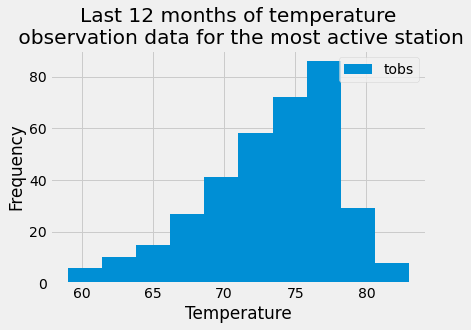

In [80]:
# Plot the results as a histogram
most_active_station_last_year_df = pd.DataFrame(most_active_station_last_year, columns=['tobs'])
plt.hist(most_active_station_last_year_df)
plt.title('Last 12 months of temperature\n observation data for the most active station')
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.legend(['tobs'],loc='upper right')
plt.show()

# Close session

In [76]:
# Close Session
session.close()